In [55]:
import os
import sys
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cities.utils.cleaning_utils import standardize_and_scale
import matplotlib.pyplot as plt
from cities.utils.data_grabber import DataGrabber

current_dir =  os.getcwd()
#parent_dir = os.path.dirname(current_dir)
#sys.path.insert(0, parent_dir)

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)


In [65]:
data = DataGrabber()
data.get_features_wide(["gdp", "population", "transport",
            "spending_transportation", "spending_commerce", "spending_HHS"])
population = data.wide['population']



In [62]:
def log10_scaling(data: pd.DataFrame) -> pd.DataFrame:
 
    float_columns = data.select_dtypes(include=['float64'])
    log10_data = float_columns.apply(np.log10)
    result = data.copy()
    result[float_columns.columns] = log10_data

    new_data = standardize_and_scale(result)

    return new_data


def sigmoid_scaling(data: pd.DataFrame) -> pd.DataFrame:

    float_columns = data.select_dtypes(include=['float64'])
    asinh_data = float_columns.apply(lambda x: np.arcsinh(x))

    result = data.copy()
    result[float_columns.columns] = asinh_data

    new_data = standardize_and_scale(result)

    return new_data


def standarization_tool(data: pd.DataFrame, method: str = 'standard') -> pd.DataFrame:
    """

    method (str): The transformation method to apply. Options include 'standard' for standardization
    (a default option), 'log10' for log base 10 scaling, and 'sigmoid' for inverse hyperbolic sine scaling.

    it returns a dataframe with the same shape as the input dataframe, but with the values transformed
    
    """

    if method == 'standard':

        new_data = standardize_and_scale(data) 
        
    elif method == 'log10':

        new_data = log10_scaling(data) 

    elif method == 'sigmoid':
    
        new_data = sigmoid_scaling(data)

    else:
        raise ValueError("Invalid method. Supported methods are 'standard', 'log10', and 'sigmoid'.")

    return new_data




In [72]:
def cramer_mises_dist(dist1, dist2):
    return np.sum((dist1 - dist2) ** 2)


def standarization_comparison_tool(data, column):

    data_standardized = standarization_tool(data)
    data_log10 = standarization_tool(data, 'log10')
    data_sigmoid = standarization_tool(data, 'sigmoid')


    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    axes[0, 0].hist(data[column], bins=20, color='green')
    axes[0, 0].set_title(f'Histogram for {column} column, Original')
    
    axes[0, 1].hist(data_standardized[column], bins=20, color='steelblue')
    axes[0, 1].set_title(f'Histogram for {column} column, Standardized')
    
    axes[1, 0].hist(data_log10[column], bins=20, color='skyblue')
    axes[1, 0].set_title(f'Histogram for {column} column, log10')
    
    axes[1, 1].hist(data_sigmoid[column], bins=20, color='purple')
    axes[1, 1].set_title(f'Histogram for {column} column, sigmoid')
    
    plt.tight_layout()
    plt.show()

    length = len(data_standardized[column])
    mean = 0
    std_dev = 0.2  

    x = np.linspace(-1, 1, length)
    normal_distribution = np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    normal_distribution /= np.sum(normal_distribution)


  
    distance_standardized = cramer_mises_dist(normal_distribution, data_standardized[column])
    distance_log10 = cramer_mises_dist(normal_distribution, data_log10[column])
    distance_sigmoid = cramer_mises_dist(normal_distribution, data_sigmoid[column])
    
    print('Distance measurements to normal distribution, calculated with Cramer von Mises distance:')
    print(f"Distance of standard version to normal distribution (for {column} column): {distance_standardized}")
    print(f"Distance of log10 version to normal distribution (for {column} column): {distance_log10}")
    print(f"Distance of sigmoid version to normal distribution (for {column} column): {distance_sigmoid}")

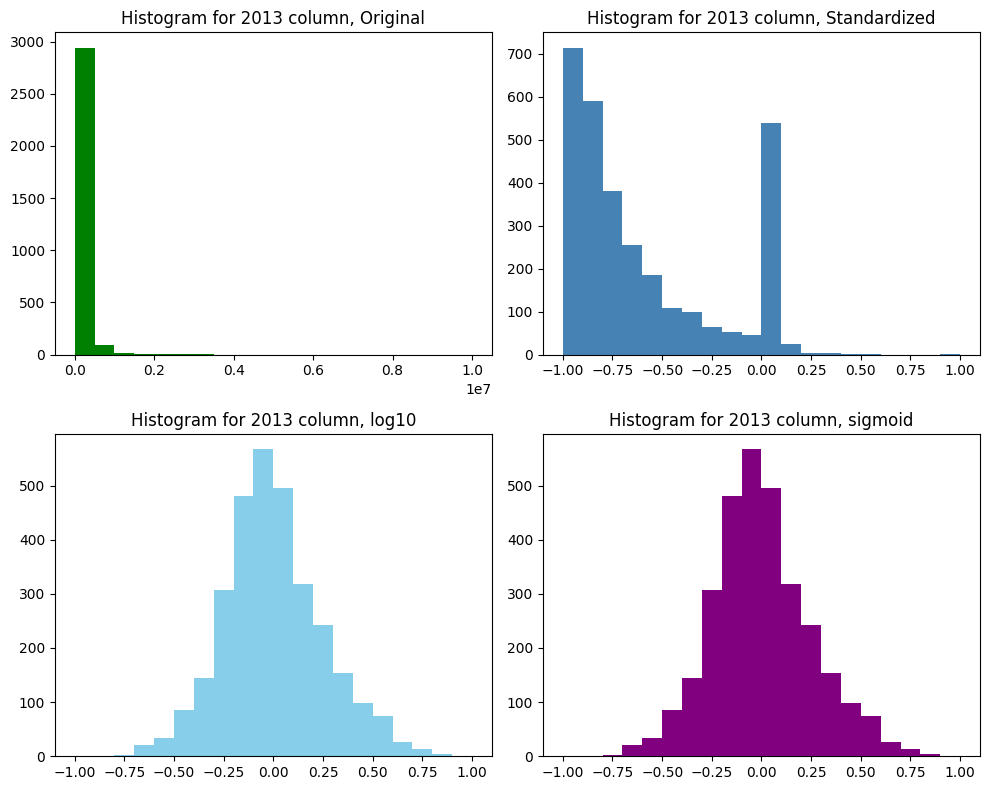

Distance measurements to normal distribution, calculated with Cramer von Mises distance:
Distance of standard version to normal distribution (for 2013 column): 1497.3569126546085
Distance of log10 version to normal distribution (for 2013 column): 193.93680545152196
Distance of sigmoid version to normal distribution (for 2013 column): 193.93801831949952


In [73]:
standarization_comparison_tool(population, '2013')